# Nanoparticle Feature Setup <a name="head"></a>

This tutorial details how to generate features from a data set of nanoparticle atoms objects. The data imported here is for 147-atom AuPt alloyed nanoprticles with varying composition and chemical ordering.

## Table of Contents
[(Back to top)](#head)

-   [Requirements](#requirements)
-   [Initialization](#initialization)
-   [Generating Feature Vectors](#generating-feature-vectors)
-   [Storing Data](#storing-data)
-   [Retrieving Date](#retrieving-data)
-   [Conclusions](#conclusions)

## Requirements <a name="requirements"></a>
[(Back to top)](#head)

-   [CatLearn](https://github.com/SUNCAT-Center/CatLearn)
-   [ASE](https://wiki.fysik.dtu.dk/ase/)
-   [numpy](http://www.numpy.org/)

## Initialization <a name="initialization"></a>
[(Back to top)](#head)

To start with we import some functions from ASE and CatLearn.

In [1]:
from IPython.display import Image

import os
import numpy as np
import random

from ase.ga.data import DataConnection
from ase.io import write

from catlearn.api.ase_data_setup import get_unique, get_train
from catlearn.api.ase_atoms_api import images_connectivity
from catlearn.featurize.setup import FeatureGenerator, default_fingerprinters
from catlearn.utilities import DescriptorDatabase

## Generating Feature Vectors <a name="generating-feature-vectors"></a>
[(Back to top)](#head)

Some data is imported from an existing `ase.db`.

In [2]:
# Connect ase atoms database.
gadb = DataConnection('../../data/gadb.db')

# Get all relaxed candidates from the db file.
all_cand = gadb.get_all_relaxed_candidates(use_extinct=False)

The nanoparticles can be displayed with the following.

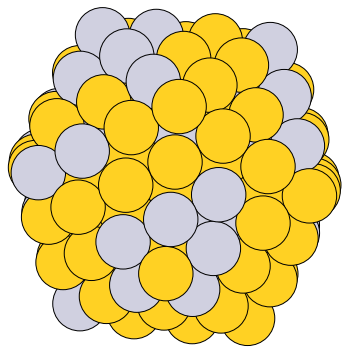

In [3]:
write('particle.png', all_cand[-100])
Image('particle.png')

There are a couple of functions that will make some selection of data for testing and training. In reality, it is far more robust to do this with some form of cross-validation, but this will suffice for this tutorial. The `get_unique` function will randomly select a defined data size. The `get_train` can then generate a training dataset with replacement. As the naming suggests, it is ensured none of the data in the unique dataset will make it into the training set.

In [4]:
testset = get_unique(atoms=all_cand, size=10, key='raw_score')
images_connectivity(testset['atoms']);
trainset = get_train(atoms=all_cand, size=30, taken=testset['taken'],
                     key='raw_score')
images_connectivity(trainset['atoms']);

100%|██████████| 30/30 [00:00<00:00, 41.44it/s]


Once the atoms objects have been prepared, it is possible to generate the feature sets. This can be performed in parallel by setting `nprocs` greater than 1. If `None` is set then all available cores will be utilized. Two functions can be called to generate the feature sets `return_vec` and the feature names `return_names`.

In [5]:
generator = FeatureGenerator(atom_types=[78, 79], nprocs=1,
                             element_parameters=['atomic_radius', 'mass'])
feature_names = default_fingerprinters(generator, 'fragment')
data = generator.return_vec(trainset['atoms'], feature_names)
vec_names = generator.return_names(feature_names)

# Sanitize names for database.
for i, f in enumerate(vec_names):
    vec_names[i] = ('f' + f).replace('-', '_')

100%|██████████| 30/30 [00:06<00:00,  4.76it/s]


## Storing Data <a name="storing-data"></a>
[(Back to top)](#head)

Once the features have been generated, it is possible to store them in a database. This initial implementation of the db isn't so optimal but is a simple way of temporarily storing all the feature vectors. The following lines of code will initialize the db.

In [6]:
# Define variables for database to store system descriptors.
descriptors = list(vec_names)
targets = ['Energy']
column_names = descriptors + targets

# Set up the database to save system descriptors.
dd = DescriptorDatabase(db_name='vec_store.sqlite')
dd.create_db(names=column_names)

The code below will then reformat the data slightly, before storing it in the db. In this case the targets are stored in the `atoms.info['key_value_pairs']['raw_score']`. To keep track of where the feature vectors come from, the atoms UUID is utilized. This is stored in `atoms.info['unique_id']`.

In [7]:
# Put data in correct format to be inserted into database.
new_data = []
for d, a in zip(data, trainset['atoms']):
    new_data.append([a.info['unique_id']] + list(d) +
    [a.info['key_value_pairs']['raw_score']])

# Fill the database with the data.
dd.fill_db(descriptor_names=column_names, data=new_data)

It is possible to update the db as required. In the following, we just append some random variables from to the db.

In [8]:
dd.create_column(new_column=['random'])

# Add new name to list of descriptors.
column_names += ['random']

for i in dd.query_db(names=['uuid']):
    dd.update_descriptor(
        descriptor='random', new_data=random.random(), unique_id=i[0])

## Retrieving Date <a name="retrieving-data"></a>
[(Back to top)](#head)

To check what data is now stored in the db, the following can be used.

In [9]:
stored = dd.get_column_names()
print('\nretrieved column names:\n{}'.format(stored))


retrieved column names:
['uuid', 'fsum_78_atomic_radius', 'fsum_79_atomic_radius', 'fsum_all_atomic_radius', 'fmean_all_atomic_radius', 'fsum_78_mass', 'fsum_79_mass', 'fsum_all_mass', 'fmean_all_mass', 'feig_0', 'feig_1', 'feig_2', 'feig_3', 'feig_4', 'feig_5', 'feig_6', 'feig_7', 'feig_8', 'feig_9', 'feig_10', 'feig_11', 'feig_12', 'feig_13', 'feig_14', 'feig_15', 'feig_16', 'feig_17', 'feig_18', 'feig_19', 'feig_20', 'feig_21', 'feig_22', 'feig_23', 'feig_24', 'feig_25', 'feig_26', 'feig_27', 'feig_28', 'feig_29', 'feig_30', 'feig_31', 'feig_32', 'feig_33', 'feig_34', 'feig_35', 'feig_36', 'feig_37', 'feig_38', 'feig_39', 'feig_40', 'feig_41', 'feig_42', 'feig_43', 'feig_44', 'feig_45', 'feig_46', 'feig_47', 'feig_48', 'feig_49', 'feig_50', 'feig_51', 'feig_52', 'feig_53', 'feig_54', 'feig_55', 'feig_56', 'feig_57', 'feig_58', 'feig_59', 'feig_60', 'feig_61', 'feig_62', 'feig_63', 'feig_64', 'feig_65', 'feig_66', 'feig_67', 'feig_68', 'feig_69', 'feig_70', 'feig_71', 'feig_72', 'fe

To retrieve the features and targets, the following can be used.

In [10]:
# Test out the database functions.
train_fingerprint = dd.query_db(names=descriptors)
train_target = dd.query_db(names=targets)

print('\nfeature data for candidates: \n{}'.format(train_fingerprint[:10, :]))
print('\ntarget data for candidates: \n{}'.format(train_target[:10, :]))


feature data for candidates: 
[[15846.0 4818.0 20664.0 ... 1.9912280701754386 6.878787878787879
  4.2727272727272725]
 [4865.0 16352.0 21217.0 ... 7.114285714285714 2.2232142857142856
  8.267857142857142]
 [695.0 20732.0 21427.0 ... 9.6 0.3380281690140845 10.04225352112676]
 ...
 [1807.0 19564.0 21371.0 ... 5.846153846153846 0.5671641791044776
  9.104477611940299]
 [8062.0 12994.0 21056.0 ... 4.637931034482759 3.0224719101123596
  6.752808988764045]
 [16263.0 4380.0 20643.0 ... 0.9572649572649573 3.7333333333333334 4.8]]

target data for candidates: 
[[-4.64861154]
 [-2.83520192]
 [ 0.24337081]
 [-2.38363488]
 [-0.86829378]
 [-3.95466123]
 [-0.3325683 ]
 [-0.39782704]
 [ 0.40325169]
 [ 1.68434206]]


Finally, the folder can be tidied up.

In [11]:
os.remove('vec_store.sqlite')
os.remove('particle.png')

## Conclusions <a name="conclusions"></a>
[(Back to top)](#head)

This tutorial has demonstrated how to generate feature vectors for nanoparticle atoms objects and store that data in a temporary db.